# Pyroomacoustics Demo

### dependencies:  pyroomacoustics, pysoundfile, samplerate

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
import soundfile

plt.rcParams['font.size'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

%matplotlib inline

import librosa
import librosa.display
import samplerate

import IPython.display as ipd

from scipy import signal

import pyroomacoustics as pra
from pyroomacoustics.doa import circ_dist

import pandas as pd

In [2]:
def plot_spec(spec, t_audio, frame_len, fs, hop=None):
    
    if hop is None:
        hop = frame_len
        
    fig, ax = plt.subplots(figsize=(20,7))
    spec = np.swapaxes(spec, 0 ,1)
    cax = ax.imshow(spec, interpolation=None, origin='lower', aspect='auto')
    ax.set_xlabel("Time [seconds]", fontsize=30)
    ax.set_ylabel("Frequency [Hz]", fontsize=30)
    x_labels = np.arange(max(t_audio), step=0.5)
    plt.xticks(x_labels*fs//hop, x_labels, fontsize=20)
    freqs = np.arange(frame_len//2+1) / frame_len * fs
    y_labels = np.arange(max(freqs)+1, step=1000).astype(np.int)
    plt.yticks(y_labels//(fs/frame_len), y_labels, fontsize=20)
    plt.tight_layout()

## Read file and show it in spectogram 

In [100]:
file_name = '../recordings/180910_142834.wav'

In [109]:
def read_sound(file_name, time=[231, 245], channel = 0):
    data, fs = soundfile.read(file_name, stop=10)
    data, fs = soundfile.read(file_name, start=time[0]*fs, stop=time[1]*fs)
    
    data = data[:,0]
    
    return data, fs

In [133]:
data, fs = read_sound(file_name)

In [136]:
data, fs = read_sound(file_name, time=[285, 287])

In [107]:
data, fs = read_sound(file_name, time=[60, 245])

In [130]:
data.shape

(88200,)

In [139]:
def spect(data, fs, fmin=100, fmax = 1000, nfft_ratio=2, overlap_ratio=16, Gain = 35, figsize=(15, 10)):

       
    # Simple API
    ratio = fmax*2./(fs)
    nfft=int(1024./nfft_ratio)
    new_fs = int(fs*ratio)
    converter = 'sinc_best'  # or 'sinc_fastest', ...
    output_data_simple = samplerate.resample(data, ratio, converter)

    sos = signal.butter(10, fmin, 'hp', fs=new_fs, output='sos')
    output_data_simple = signal.sosfilt(sos, output_data_simple)

    X = librosa.stft(output_data_simple, n_fft=nfft, hop_length=int(nfft/(overlap_ratio*1.)))

    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=figsize)
    librosa.display.specshow(Xdb, sr=new_fs, x_axis='time', y_axis='hz', fmin=0, fmax=fmax, cmap='inferno')


    soundfile.write('test.wav', 10**(Gain/20.)*output_data_simple,samplerate=new_fs)

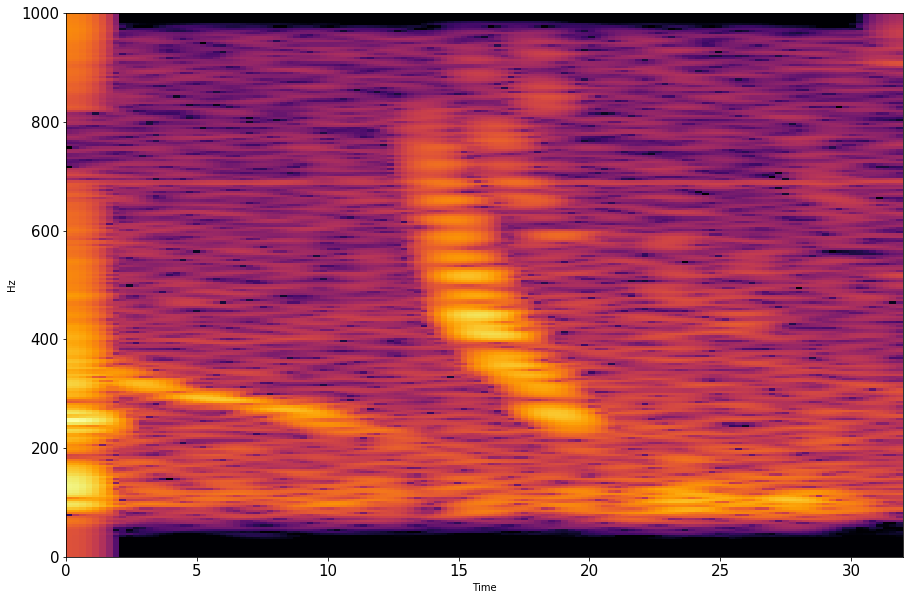

In [140]:
spect(data, fs)

## Create room 

In [199]:
def sim_room(signal, fs, room_dim = [10000, 10000, 10000], r_source=[5000, 5000, 9995],
             r_rec=np.c_[
    [5005, 5000, 9995],  # mic 1
    [5005, 5000, 9990],  # mic 2
    ], **kwargs):
    
    if 'max_order' in kwargs.keys():
        max_order = kwargs['max_order']
    else:
        max_order = 5
    
    if 'absorption' in kwargs.keys():
        absorption = kwargs['absorption']
    else:
        absorption = 0.5
        
    
    scale_fact = 10000.
    room_dim = np.array(room_dim)/scale_fact
    r_source = np.array(r_source)/scale_fact
    r_rec = np.array(r_rec)/scale_fact
    
    aroom = pra.ShoeBox(room_dim, fs=fs, max_order=max_order, absorption=absorption)
    aroom.add_source(R_source, signal=data)
    mic_array = pra.MicrophoneArray(r_rec, aroom.fs)
    aroom.add_microphone_array(mic_array)

    aroom.plot()
    
    aroom.compute_rir()
    aroom.simulate()
    
    out_signal = aroom.mic_array.signals
    
    # normalize to originl sound levels
    org_ENR = np.sum(signal**2)
    new_ENR = np.sum(out_signal**2, axis=1).max()
    

    return np.sqrt(org_ENR/new_ENR)*out_signal

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


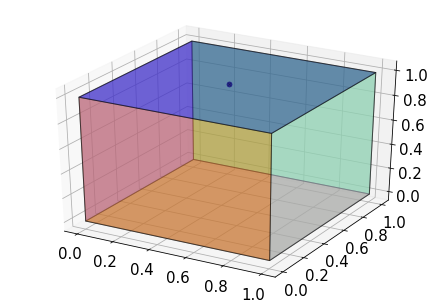

In [200]:
rec_signal = sim_room(data, fs, absorption=0.1)

In [201]:
# this is the result for each mike

rec_signal.shape

(2, 89092)

### note that aroom.mic_array.signals is normalized and not in original amplitude

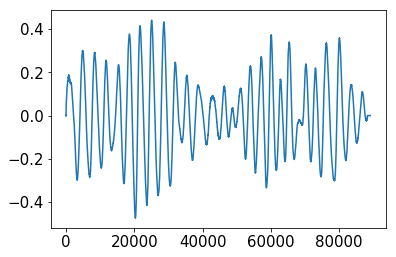

In [202]:
plt.plot(rec_signal[0,:])
plt.show()

# Add sea noise

In [203]:
sea_noise_times = pd.read_csv('silence_180910_142834.txt', sep=' ', header=None).values
sea_noise_times

array([[292, 294],
       [408, 410],
       [467, 469],
       [518, 520],
       [571, 573]])

In [204]:
noise_data.shape

(2, 88200)

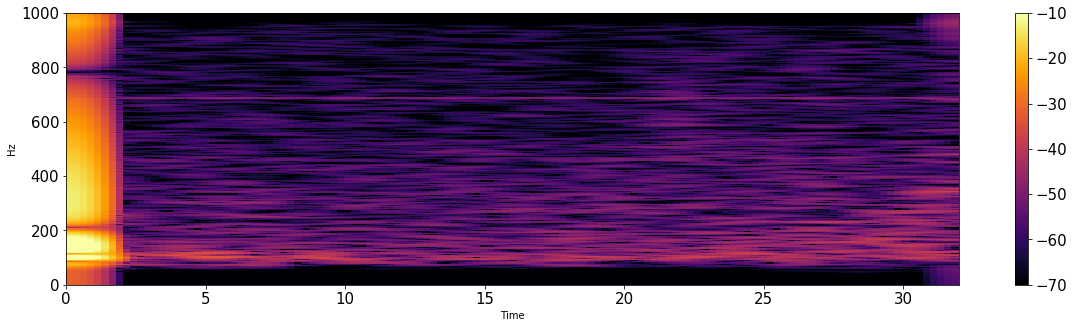

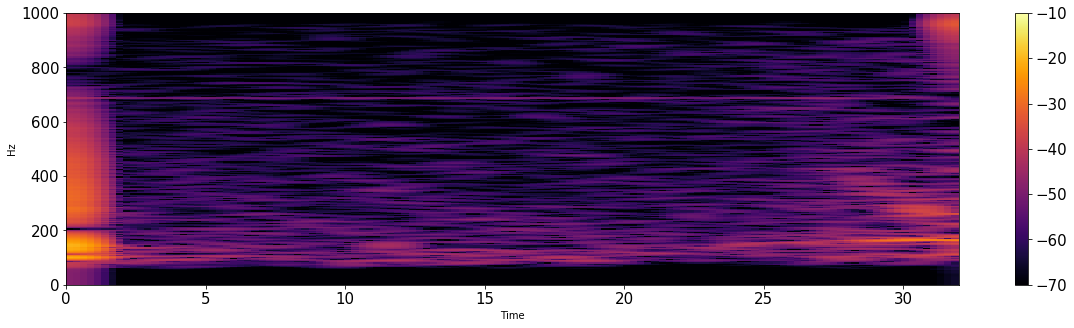

In [205]:
noise_data_1, _ = read_sound(file_name, sea_noise_times[0, :])
noise_data_2, _ = read_sound(file_name, sea_noise_times[1, :])
noise_data = np.concatenate((noise_data_1.reshape(1,-1), noise_data_2.reshape(1,-1)), axis=0)

spect(noise_data[0,:], fs, figsize=[20,5])
plt.colorbar()
plt.clim((-70,-10))
spect(noise_data[1,:], fs, figsize=[20,5])
plt.colorbar()
plt.clim((-70,-10))


In [206]:
rec_signal = rec_signal[:, :noise_data.shape[1]] + noise_data

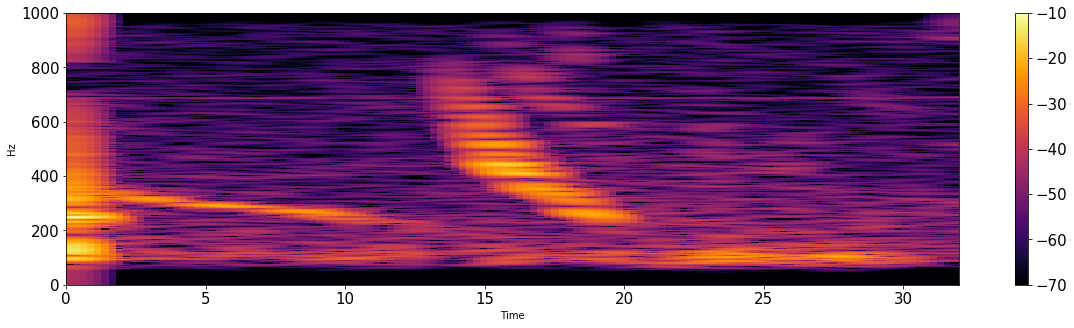

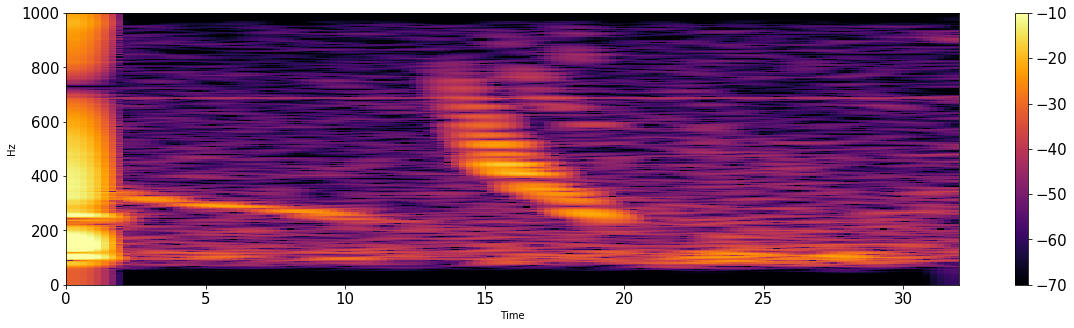

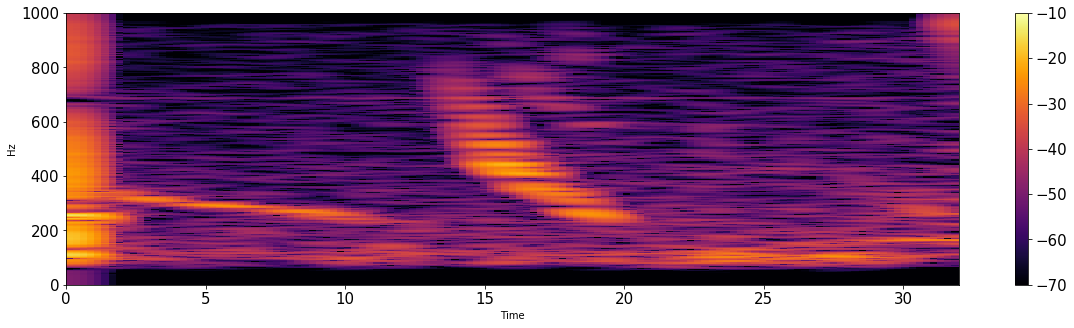

In [207]:
spect(data, fs, figsize=[20,5])
plt.colorbar()
plt.clim((-70,-10))

spect(rec_signal[0,:], fs, figsize=[20,5])
plt.colorbar()
plt.clim((-70,-10))

spect(rec_signal[1,:], fs, figsize=[20,5])
plt.colorbar()
plt.clim((-70,-10))



# Music